In [1]:
%matplotlib inline
# Import Dependencies
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
# Create an engine for the database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [4]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [5]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [6]:
# Create the inspector and connect it to the engine 
inspector = inspect(engine)
inspector.get_table_names() 

# Get variables in the measurement
columns_measurement = inspector.get_columns("measurement")
for column in columns_measurement:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# Get variables in the station
columns_station = inspector.get_columns("station")
for cols in columns_station:
    print(cols["name"], cols["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Get the last date in the table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print("The last date in the table %s "%(last_date))
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=366)
print("12 months ago is %s" %(last_year))

The last date in the table 2017-08-23 
12 months ago is 2016-08-22


In [9]:
# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
       filter(Measurement.date > last_year).\
       order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp).set_index("date")
prcp_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


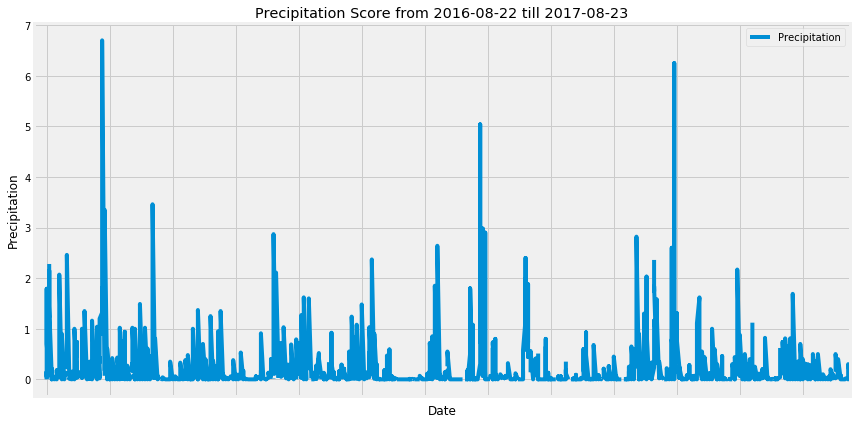

In [10]:
# Use Pandas Plotting with Matplotlib to plot the data
X_axis = prcp_df.index
Y_axis = prcp_df["prcp"]

fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(X_axis, Y_axis)
plt.legend(["Precipitation"])

ax.set_title(f'Precipitation Score from {last_year} till %s'%(last_date))

ax.set_xlabel("Date")
ax.set_ylabel("Precipitation")

ax.set_xlim(-5, len(X_axis)/7);
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.xaxis.set_major_formatter(plt.NullFormatter())

plt.tight_layout()
plt.savefig("./Figures/precipitation_score_1yr.png")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
station_number = session.query(Station).count()
print("There are {} stations in total.".format(station_number))

There are 9 stations in total.


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_active = session.query(Measurement.station, func.count(Measurement.station)).\
                 group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
station_active_most = station_active[0]

print(f"Station {station_active_most[0]} have the highest number of observations: {station_active_most[1]}")

Station USC00519281 have the highest number of observations: 2772


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_station_active_most = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == station_active_most [0]).all()

print (f"The lowest, highest and average temperature recorded \
of station {station_active_most[0]} are {temp_station_active_most[0][0]}, \
{temp_station_active_most[0][1]}, \
{np.round(temp_station_active_most[0][2],2)} Fahrenheit")

The lowest, highest and average temperature recorded of station USC00519281 are 54.0, 85.0, 71.66 Fahrenheit


In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_lastyear_station_active_most = session.query( Measurement.station, Measurement.date, Measurement.tobs).\
                                    filter(Measurement.date > last_year).\
                                    filter(Measurement.station == station_active_most [0]).all()

Last12_tobs_DF = pd.DataFrame(temp_lastyear_station_active_most).set_index("station")
Last12_tobs_DF.head()

,date,tobs
station,,
USC00519281,2016-08-23,77.0
USC00519281,2016-08-24,77.0
USC00519281,2016-08-25,80.0
USC00519281,2016-08-26,80.0
USC00519281,2016-08-27,75.0


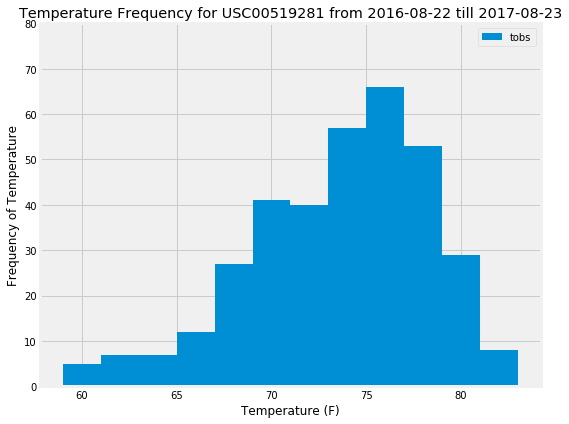

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(Last12_tobs_DF["tobs"], bins=12, label="tobs")
plt.legend(["tobs"])

plt.title(f'Temperature Frequency for {station_active_most[0]} from {last_year} till {last_date[0]}')
plt.ylim(0,80)
plt.ylabel("Frequency of Temperature")
plt.xlabel("Temperature (F)")

plt.tight_layout()
plt.savefig("./Figures/Temperature_Stations.png")
plt.show()

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2017-01-01'
trip_end = '2017-01-15'
temp_trip = calc_temps(trip_start, trip_end)
print(temp_trip)

[(60.0, 68.5505617977528, 81.0)]


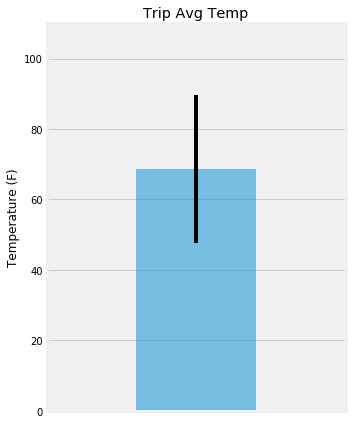

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin = temp_trip[0][0]; tavg = temp_trip[0][1]; tmax = temp_trip[0][2]
y_err = tmax-tmin

fig, ax = plt.subplots(figsize=(5, 6))
plt.bar(0, tavg, yerr=y_err, align='center', alpha=0.5, ecolor='black')
plt.title('Trip Avg Temp')
plt.xlim(-1, 1)
plt.ylim(0, 110)

plt.setp(ax.get_xticklabels(), visible=False)
ax.xaxis.grid()
ax.set_ylabel("Temperature (F)")

plt.tight_layout()
plt.savefig("./Figures/Temperature.png")
plt.show()


In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

rainfall_per_station = session.query(*sel).\
                       filter(Measurement.station == Station.station).\
                       filter(Measurement.date >= trip_start).filter(Measurement.date <= trip_end).\
                       group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
rainfall_per_station_df = pd.DataFrame(rainfall_per_station, \
                          columns=["station", "station name", "latitude", "longitude", "elevation", \
                                  "total rainfall"])
rainfall_per_station_df.head()

,station,station name,latitude,longitude,elevation,total rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.64
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.63
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.61
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.35
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.21


## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Use the start and end date to create a range of dates
date_range = session.query(Measurement.date).\
             filter(Measurement.date >= trip_start).filter(Measurement.date <= trip_end).\
             group_by(Measurement.date).all()

# Stip off the year and save a list of %m-%d strings
trip_month_day = [d[0][5:] for d in date_range]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(d)[0] for d in trip_month_day]

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df= pd.DataFrame(normals, columns=["tmin", "tavg", "tmax"])
normals_df["date"] = [d[0] for d in date_range]
normals_df_new = normals_df.set_index("date")
normals_df_new.head()

,tmin,tavg,tmax
date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0


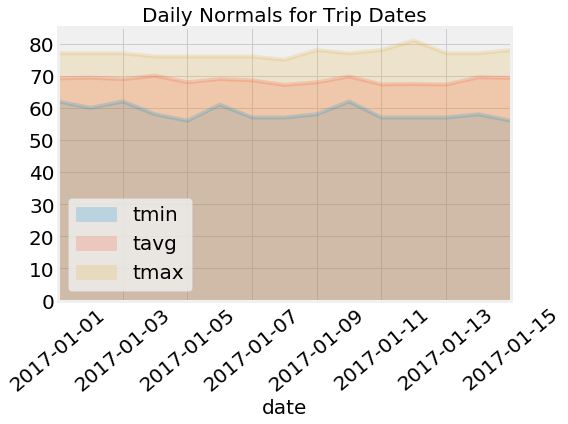

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df_new.plot(kind='area', alpha=.2, \
                    stacked=False, x_compat=True, \
                    figsize=(8,6),  fontsize =20, rot=40)
plt.legend(loc=3, prop={'size': 20})
plt.title("Daily Normals for Trip Dates", fontsize=20)
plt.xlabel('date', fontsize=20)
plt.tight_layout()
plt.savefig("./Figures/DailyNormals.png")
plt.show()